=== ☁️ Your Weather Assistant (Widget Mode) ☁️ ===


ToggleButtons(button_style='info', description='Choose:', options=('Ask Weather Question', 'Visualize Temperat…

Output()

⚠️ Could not understand your weather request.


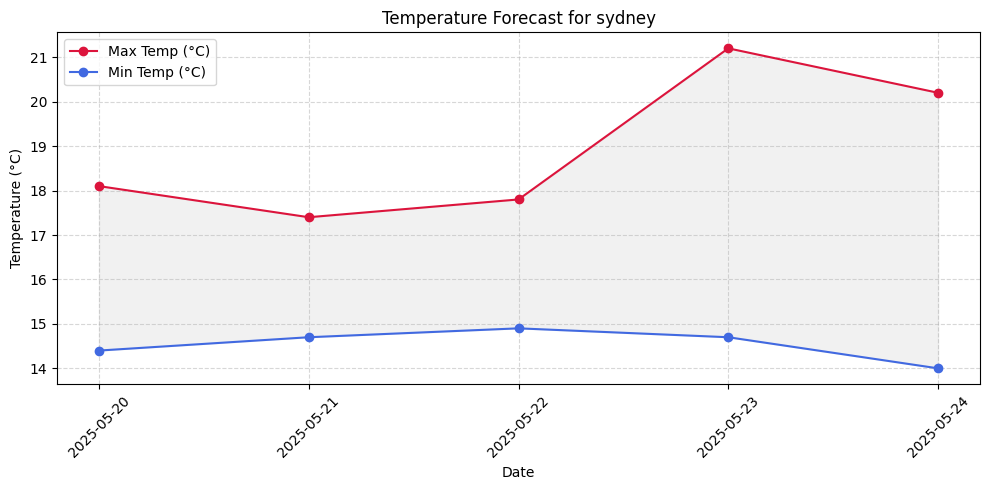

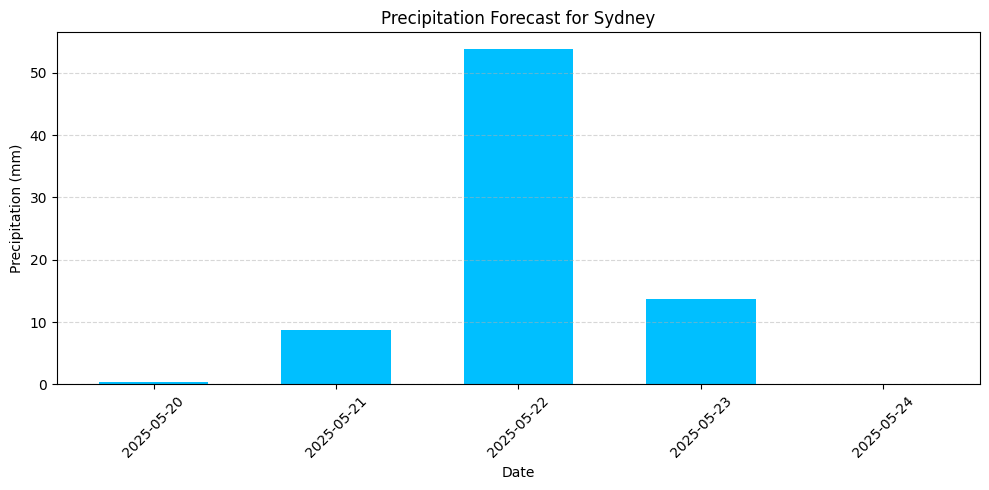

In [2]:
# 🧪 Install required packages (quiet mode)
!pip install -q requests matplotlib pandas pyinputplus

# ✅ Imports
import requests
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import re
import pyinputplus as pyip
from typing import Dict, Any

# ✅ Geocoding using OpenStreetMap Nominatim
def geocode_location(location: str) -> tuple[float, float]:
    url = "https://nominatim.openstreetmap.org/search"
    params = {'q': location, 'format': 'json', 'limit': 1}
    headers = {'User-Agent': 'weather-colab'}  # ✅ Required by Nominatim
    response = requests.get(url, params=params, headers=headers)
    response.raise_for_status()
    data = response.json()
    if not data:
        raise ValueError(f"❌ Location '{location}' not found.")
    return float(data[0]['lat']), float(data[0]['lon'])


# ✅ Fetch weather data from Open-Meteo API
def fetch_weather(lat: float, lon: float, start_date: str, end_date: str) -> Dict[str, Any]:
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        'latitude': lat,
        'longitude': lon,
        'daily': 'temperature_2m_max,temperature_2m_min,precipitation_sum',
        'current_weather': True,
        'timezone': 'auto',
        'start_date': start_date,
        'end_date': end_date
    }
    return requests.get(url, params=params).json()

# ✅ Extract forecast data
def _extract_forecast_data(weather_data, keys):
    forecast = weather_data.get('forecast', [])
    return [[day.get(k, None) for day in forecast] for k in keys]

# ✅ Get full weather data
def get_weather_data(location: str, forecast_days: int = 5) -> Dict[str, Any]:
    forecast_days = min(max(forecast_days, 1), 5)
    lat, lon = geocode_location(location)
    today = datetime.date.today()
    end_date = today + datetime.timedelta(days=forecast_days - 1)
    raw_data = fetch_weather(lat, lon, today.isoformat(), end_date.isoformat())
    result = {
        'location': location,
        'latitude': lat,
        'longitude': lon,
        'current': raw_data.get('current_weather', {}),
        'forecast': []
    }
    daily = raw_data.get('daily', {})
    for date, t_max, t_min, precip in zip(
        daily.get('time', []),
        daily.get('temperature_2m_max', []),
        daily.get('temperature_2m_min', []),
        daily.get('precipitation_sum', [])
    ):
        result['forecast'].append({
            'date': date,
            'temp_max': t_max,
            'temp_min': t_min,
            'precipitation': precip
        })
    return result

# ✅ Plot temperature
def create_temperature_visualisation(weather_data, output_type='display'):
    dates, temp_max, temp_min = _extract_forecast_data(weather_data, ['date', 'temp_max', 'temp_min'])
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(dates, temp_max, label='Max Temp (°C)', marker='o', color='crimson')
    ax.plot(dates, temp_min, label='Min Temp (°C)', marker='o', color='royalblue')
    ax.fill_between(dates, temp_min, temp_max, color='lightgray', alpha=0.3)
    ax.set_title(f"Temperature Forecast for {weather_data.get('location', 'Unknown')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    return fig if output_type == 'figure' else plt.show()

# ✅ Plot precipitation
def create_precipitation_visualisation(weather_data, output_type='display'):
    forecast = weather_data.get('forecast', [])
    if forecast:
        dates, precipitation = zip(*[
            (day.get('date', 'Unknown'),
             day.get('precipitation') if day.get('precipitation') is not None else 0)
            for day in forecast if 'date' in day
        ])
    else:
        dates, precipitation = ([], [])
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(dates, precipitation, color='deepskyblue', width=0.6)
    ax.set_title(f"Precipitation Forecast for {weather_data.get('location', 'Unknown')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Precipitation (mm)")
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    return fig if output_type == 'figure' else plt.show()

# ✅ Natural language parsing
def parse_weather_question(question):
    original = question
    question = question.lower()
    location = None
    time_period = 'today'
    weather_attribute = 'general'
    is_vague = False

    if 'tomorrow' in question:
        time_period = 'tomorrow'
    elif 'soon' in question or 'later' in question:
        time_period = 'next_1_days'
    else:
        match = re.search(r'next (\d+) days', question)
        if match:
            time_period = f"next_{match.group(1)}_days"

    if any(term in question for term in ['temperature', 'temp', 'hot', 'cold']):
        weather_attribute = 'temperature'
    elif any(term in question for term in ['rain', 'precipitation', 'snow', 'wet']):
        weather_attribute = 'precipitation'
    elif 'forecast' in question:
        weather_attribute = 'forecast'
    elif 'humidity' in question:
        weather_attribute = 'humidity'
    elif 'wind' in question:
        weather_attribute = 'wind'

    location_match = re.search(r'\bin ([a-z\s\-]+)', question)
    if location_match:
        location = location_match.group(1).strip()
    else:
        caps = re.findall(r'\b[A-Z][a-z]+(?:\s[A-Z][a-z]+)?', original)
        if caps:
            location = ' '.join(caps)

    if not location or weather_attribute == 'general':
        is_vague = True

    return {
        'location': location,
        'time_period': time_period,
        'weather_attribute': weather_attribute,
        'is_vague': is_vague
    }

# ✅ Generate a response
def generate_weather_response(parsed: dict, weather_data: dict) -> str:
    location = parsed['location']
    time = parsed['time_period']
    attr = parsed['weather_attribute']
    forecast = weather_data.get('forecast', [])
    current = weather_data.get('current', {})
    if parsed['is_vague']:
        return "❗ Please include a location and weather detail (e.g. temperature or rain)."
    if attr == 'temperature':
        if time == 'today':
            return f"🌡️ Today in {location}, temperature ranges from {forecast[0]['temp_min']}°C to {forecast[0]['temp_max']}°C."
        elif time.startswith('next_'):
            days = int(time.split('_')[1])
            temps = [f"{d['date']}: {d['temp_min']}°C - {d['temp_max']}°C" for d in forecast[:days]]
            return "🌡️ Temperature forecast:\n" + "\n".join(temps)
    elif attr == 'precipitation':
        if time == 'today':
            return f"🌧️ Today in {location}, precipitation: {forecast[0]['precipitation']} mm."
        elif time.startswith('next_'):
            days = int(time.split('_')[1])
            rain = [f"{d['date']}: {d['precipitation']} mm" for d in forecast[:days]]
            return "🌧️ Rain forecast:\n" + "\n".join(rain)
    elif attr == 'wind':
        return f"💨 Wind speed in {location} is {current.get('windspeed', 'unknown')} km/h."
    elif attr == 'humidity':
        return "💧 Humidity data is not available from this API."
    return "⚠️ Could not understand your weather request."

# ✅ Location validator
def get_location_input():
    def validate(input_str):
        s = input_str.strip()
        if not re.match(r'^[a-zA-Z\s\-]+$', s): raise ValueError("Only letters, spaces, or hyphens.")
        if len(s) < 2: raise ValueError("Too short.")
        return s
    return pyip.inputStr(prompt="🌍 Enter location (e.g., Sydney): ", applyFunc=validate)

# ✅ Menu and interface
def main_menu():
    return pyip.inputMenu(
        ["Ask Weather Question", "Visualize Temperature", "Visualize Precipitation", "Exit"],
        lettered=True, numbered=False, prompt="\n🌦️ What would you like to do?\n"
    )

import ipywidgets as widgets
from IPython.display import display, clear_output

def run_interface_widgets():
    print("=== ☁️ Your Weather Assistant (Widget Mode) ☁️ ===")

    menu = widgets.ToggleButtons(
        options=["Ask Weather Question", "Visualize Temperature", "Visualize Precipitation", "Exit"],
        description='Choose:',
        button_style='info'
    )
    display(menu)

    output = widgets.Output()
    display(output)

    def on_menu_change(change):
        if change['name'] == 'value' and change['new']:
            output.clear_output()
            with output:
                choice = change['new']
                if "Ask" in choice:
                    question_box = widgets.Text(
                        value='',
                        placeholder='Will it rain in Paris tomorrow?',
                        description='Question:',
                        style={'description_width': 'initial'},
                        layout=widgets.Layout(width='100%')
                    )
                    ask_button = widgets.Button(description="Get Weather", button_style='primary')

                    def ask_action(b):
                        parsed = parse_weather_question(question_box.value)
                        if not parsed['location']:
                            print("❌ Please specify a location.")
                            return
                        data = get_weather_data(parsed['location'])
                        print(generate_weather_response(parsed, data))

                    ask_button.on_click(ask_action)
                    display(question_box, ask_button)

                elif "Temperature" in choice or "Precipitation" in choice:
                    location_input = widgets.Text(
                        value='',
                        placeholder='e.g., Sydney',
                        description='Location:',
                        style={'description_width': 'initial'},
                        layout=widgets.Layout(width='50%')
                    )
                    vis_button = widgets.Button(description="Show Chart", button_style='primary')

                    def vis_action(b):
                        loc = location_input.value.strip()
                        if not re.match(r'^[a-zA-Z\s\-]{2,}$', loc):
                            print("❌ Invalid location. Use letters, spaces, or hyphens.")
                            return
                        data = get_weather_data(loc)
                        if "Temperature" in choice:
                            create_temperature_visualisation(data)
                        else:
                            create_precipitation_visualisation(data)

                    vis_button.on_click(vis_action)
                    display(location_input, vis_button)

                elif "Exit" in choice:
                    print("👋 Exiting. Stay dry! Have a nice day!")

    menu.observe(on_menu_change)


# ✅ Run it
run_interface_widgets()